# Copy_Paste

In [271]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt
import json
import os
from skimage.measure import find_contours

In [273]:
# 재현성
random.seed(42)
np.random.seed(42)

# 1. 환경 설정

In [289]:
###### 데이터 파일 위치 ######
data_path = '/opt/ml/input/data'

###### 데이터 json 위치 ######
json_path = '/opt/ml/input/data/train.json'

##### 이미지 생성 dir 이름 ######
copy_paste_dir_name = "cp_04"

##### json 생성 이름 ######
copy_paste_json_name = "train_copy.json"

In [305]:
transform = A.Compose([
        A.RandomScale(scale_limit=(0.1,1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(512, 512, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(512, 512),
        CopyPaste(blend=True, sigma=1, pct_objects_paste=0.8, p=1.) #pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

data = CocoDetectionCP(
    data_path, 
    json_path, 
    transform
)

loading annotations into memory...
Done (t=3.76s)
creating index...
index created!


# 2. copy-paste 예시 시각화

In [306]:
# 시각화를 여러번 돌리면 합성된 사진이 달라진다.
# 같은 파일 공유를 위해서 3번 시각화하고 (너구리가 나오면) 다음으로 넘어가기

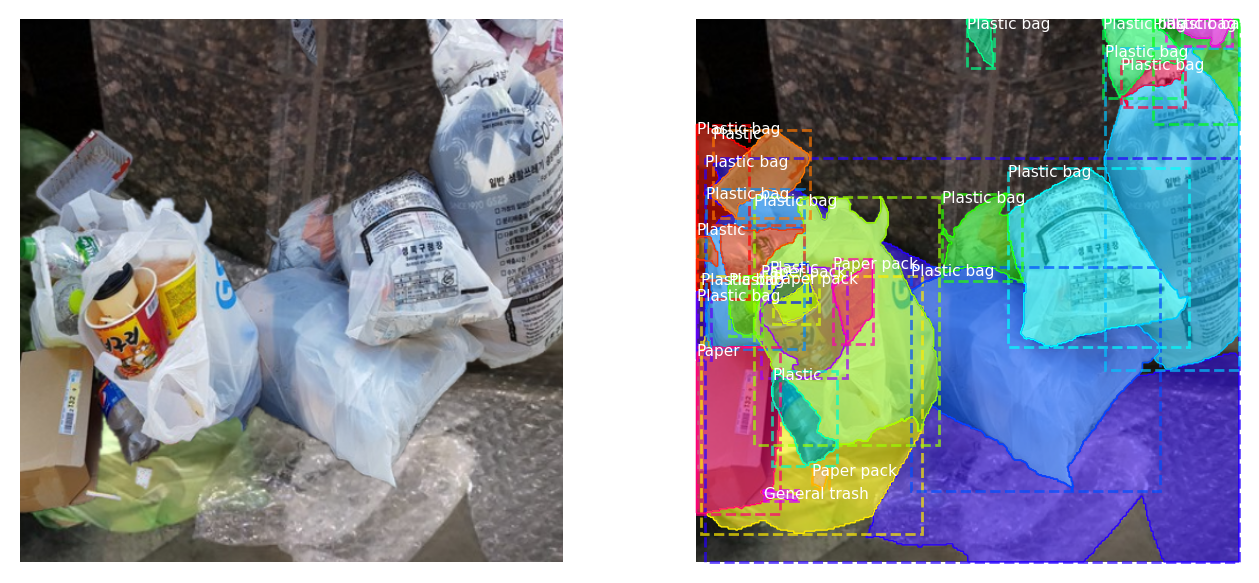

In [309]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))
index = 42
img_data = data[index]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']

empty = np.array([])
display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([b[-1] for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
    display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
else:
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])

# 3. copy-paste 파일 만들기

In [310]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [311]:
with open(json_path, 'r') as f:
    json_data = json.load(f)
    createDirectory(os.path.join(data_path, copy_paste_dir_name))
    image_list = []
    annotation_list = []
    cnt = 0
    for idx, img_data in enumerate(data):
        image_name = f"{idx:04}.jpg"
        
        # 이미지 저장
        cv2.imwrite(os.path.join(data_path,copy_paste_dir_name,image_name), img_data['image'])
        
        # json 이미지 설명란 # json_data['images']
        image_dict = {
            'license': 0,
            'url': None,
            'height': 512,
            'width': 512,
            'date_captured': None,
            'id': idx}
        image_dict['file_name'] = os.path.join(copy_paste_dir_name,image_name)
        image_list.append(image_dict)

        
        # json annotation # json_data['annotations']
        for annotation in img_data['bboxes']:
            annotation_dict = {'iscrowd' : 0}
            annotation_dict['id'] = cnt
            cnt += 1
            annotation_dict['category_id'] = annotation[-2]
            annotation_dict['bbox'] = list(annotation[0:4])
            annotation_dict['image_id'] = idx
            mask_indices = annotation[-1]
            mask_table = img_data['masks'][mask_indices]
            mask_list = []
            annotation_dict["area"] = np.count_nonzero(mask_table)
            mask_table = np.pad(mask_table,((1,1),(1,1)), constant_values=0)
            contours = find_contours(mask_table,0.5)
            for contour in contours:
                mask_inner_list = []
                for contour_value in contour:
                    mask_inner_list.append(contour_value[1]-1)
                    mask_inner_list.append(contour_value[0]-1)
                if len(mask_inner_list) > 4:
                    mask_list.append(mask_inner_list)         
            annotation_dict['segmentation'] = mask_list
            if len(mask_list) != 0:
                annotation_list.append(annotation_dict)

    json_data['images'] = image_list
    json_data['annotations'] = annotation_list

    with open(os.path.join(data_path,copy_paste_json_name), 'w') as f:
        json.dump(json_data, f, indent= "\t")
            
        

# 4. 확인하기

In [312]:
with open(os.path.join(data_path,copy_paste_json_name), 'r') as f:
    test_data = json.load(f)

In [313]:
# 데이터가 생성된 폴더 안의 이미지의 개수와 같은 지 확인 #


len(test_data["images"])

2616

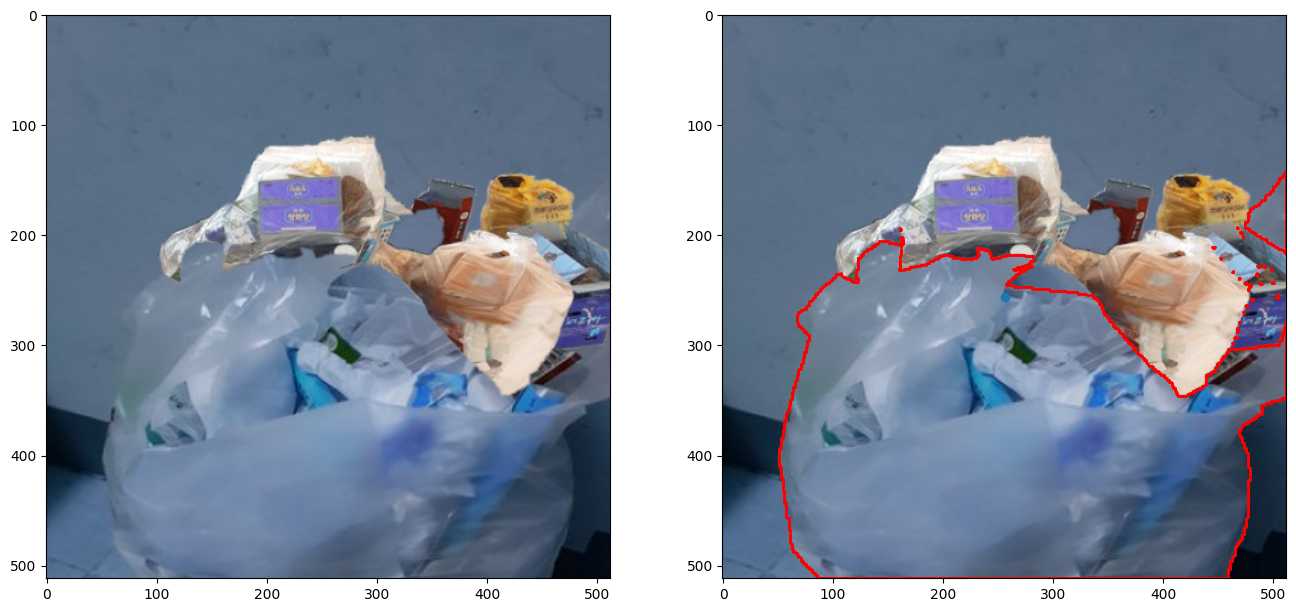

In [314]:
# 이미지 파일에서 영역이 잘 나타나는지 확인 #


import matplotlib.pyplot as plt
import matplotlib.image as img
f, ax = plt.subplots(1, 2, figsize=(16, 16))

#### 이미지 파일 위치 ####
img_test = img.imread("/opt/ml/input/data/cp_04/0000.jpg")


ax[0].imshow(img_test)
ax[1].imshow(img_test)

#### annotation id  list####
l = [0]

x = []
y = []

for i in l:
    for j in range(len(test_data['annotations'][i]['segmentation'])):
        for idx, k in enumerate(test_data['annotations'][i]['segmentation'][j]):
            if idx % 2 == 0:
                x.append(k)
            else:
                y.append(k)
ax[1].scatter(x,y, alpha = 1.0, color = "r", s = 1.0)
ax[1].scatter([256],[256]) # 중간 점
